In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split # For splitting the data for testing purposes
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

import seaborn as sns # For visualisations
import statsmodels.api as sm # For linear regression modelling
from statsmodels.graphics.gofplots import qqplot

from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import the full, labelled data set
pots = pd.read_csv('Pots_clean_labelled.csv')
pots.head(1)

productcode  price       maker                            name  \
0   AM470Y165   47.0  Andy Mason  ovalled bowl cream satin motif   

                                         description  height  width  depth  \
0  this stoneware bowl is wheel-thrown with a cre...     8.0   25.5   22.0   

   materials technique    firing decoration category  
0  Stoneware    Thrown  Electric      Glaze    first

In [3]:
pots_encoded = pd.get_dummies(
                                pots.drop(columns=['productcode', 'name', 'maker', 'description']),
                                drop_first=True #Always drop one category as information is encoded in subsequent vars
                            )
pots_encoded.columns

Index(['price', 'height', 'width', 'depth', 'materials_Earthenware',
       'materials_Porcelain', 'materials_Stoneware', 'technique_Thrown',
       'firing_Gas', 'firing_Raku', 'firing_Wood', 'decoration_Lustre',
       'decoration_Sgraffito', 'decoration_Slip decoration',
       'decoration_Terra Sigillata', 'category_first', 'category_fourth',
       'category_second', 'category_third'],
      dtype='object')

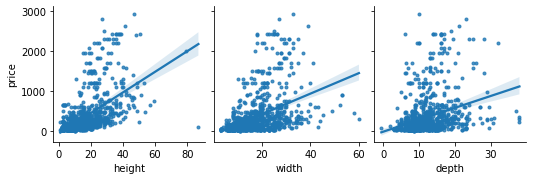

In [4]:
cols = pots_encoded.columns.drop('price')
n_cols = 3

for i in range(0, len(cols), n_cols):
    sns.pairplot(data=pots_encoded[pots_encoded['price'] < 3000], #exclude most expensive pots for visual purposes
             x_vars=cols[i:i+n_cols], 
             y_vars=['price'],
             markers='.',
             diag_kind=None, #needed to avoid broken pairplot logic (as of version 0.11.1)
             kind='reg')
    plt.show()
    break

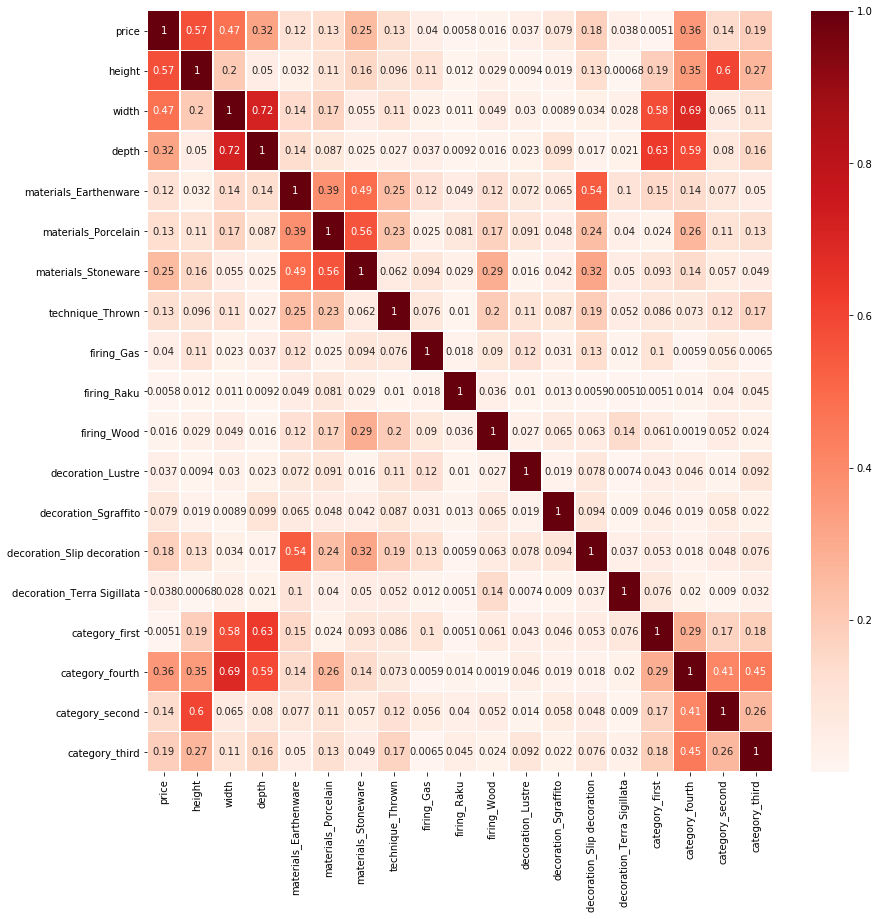

In [5]:
plt.figure(figsize=(14, 14))
sns.heatmap(abs(pots_encoded.corr()), annot = True, linewidths = 0.5, cmap = 'Reds')

There are three correlation clusters to take care of:
1. Width, depth
2. materials_Earthenware, materials_Porcelain, materials_Stoneware

Let's use the mean of width and depth and call it 'length'

In [6]:
pots_reg = pots_encoded.copy()

In [7]:
pots_reg['length'] = pots_reg[['depth', 'width']].mean(axis=1)
pots_reg.drop(columns=['depth', 'width'], inplace = True)

I will deal with the multicollinearity of the materials categorical variables using a regularized approach, if need be.

## Regressor function

In [8]:
# regression function that returns predictions
def regressor(X, y, regression_class):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

    lin_reg = regression_class
    lin_reg.fit(X_train, y_train)

    print('intercept:', round(lin_reg.intercept_, 1))
    print('coefficients:', dict(zip(X.columns, lin_reg.coef_)))

    preds_train = lin_reg.predict(X_train)
    preds_test = lin_reg.predict(X_test)
    preds_all = lin_reg.predict(X)
    residuals = y - preds_all
    
    return X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals

# calculate regression errors
def reg_errors(y_test, preds_test):
    
    mae = mean_absolute_error(y_test, preds_test)
    rmse = mean_squared_error(y_test, preds_test, squared=False)
    r2 = r2_score(y_test, preds_test)
    
    return mae, rmse, r2

#plot of regression and it's assumptions.
# func argument can be the regressor function, or any other function. log_regressor and lasso_regressor are others.
def reg_plots(func, string_description, order):
    
    X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals = func

    mae, rmse, r2 = reg_errors(y_test, preds_test)
    
    fig, axes = plt.subplots(2,2,figsize=(15,15))

    fig.suptitle("Regression: {}\n \
                 MAE = £{} \n \
                 RMSE = £{} \n \
                 R2 = {}".format(string_description, round(mae, 1), round(rmse, 1), round(r2,3)))

    sns.regplot(x=y, y=preds_all, ax=axes[0,0], scatter_kws={'s': 2}, order=order)
    axes[0,0].set_xlabel("Observed values")
    axes[0,0].set_ylabel("Predicted values")


    
    sns.histplot(residuals, kde = True, bins = 100, ax=axes[0,1])
    axes[0,1].set_title("Distribution of residuals (= y - predicted)")

    qqplot(residuals, line='45', fit=True, ax=axes[1,0])
    axes[1,0].set_title("Q-Q plot")

    sns.scatterplot(x=preds_all, y=residuals, ax=axes[1,1])
    axes[1,1].set_xlabel("predicted price")
    axes[1,1].set_ylabel("residuals")
    axes[1,1].set_title("residuals vs price predicted")

## Simple linear regression

intercept: -98.6
coefficients: {'height': 29.962495391983268}


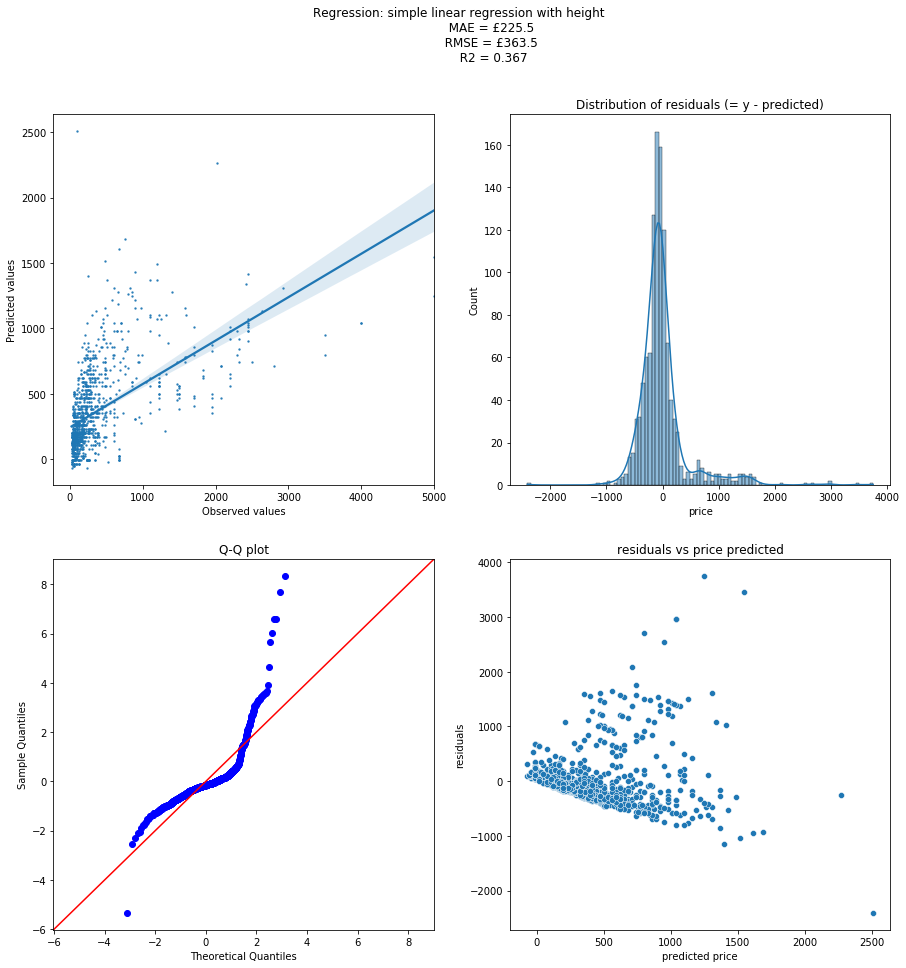

In [9]:
X = pots_reg[['height']]
y = pots_reg['price']

reg_plots(regressor(X, y, LinearRegression()), 'simple linear regression with height', order=1)

## Simple linear regression (Polynomial order = 2)

intercept: -174.0
coefficients: {'height': 38.934362114459674, 'height2': -0.17891223690970232}


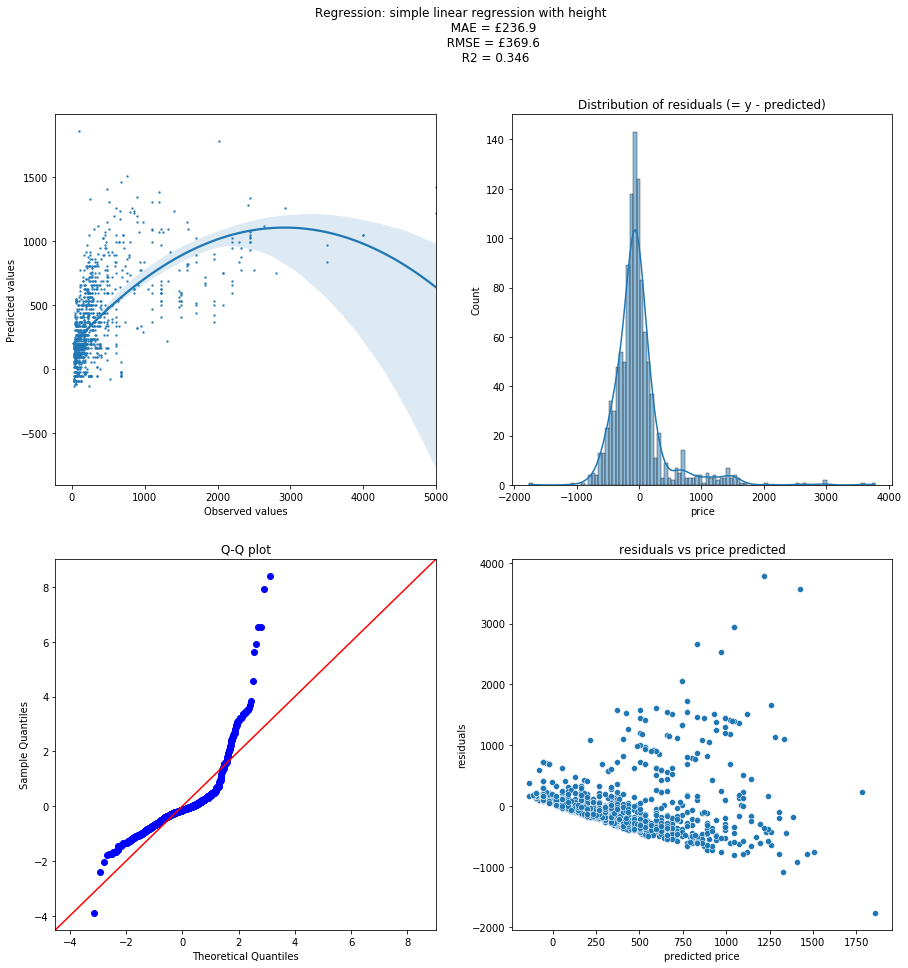

In [10]:
X = pots_reg[['height']]
X['height2'] = X['height']**2

y = pots_reg['price']

reg_plots(regressor(X, y, LinearRegression()), 'simple linear regression with height', order =2)

Initial results with what is clearly the most important variable is already indicating that something will have to be done with the data in order to make it more appropriate for a regression analysis. 

To consider, and looking at the distribution of the residuals, is to apply some log-normal transformation. 

Additionally, I will consider stripping out the higher value pots, as it may well be that they are from a small and select number of makers only.

Firstly, let's try a multiple linear regression.

## Multiple linear regressions

intercept: -541.6
coefficients: {'height': 24.351624392125043, 'materials_Earthenware': -107.08983939188668, 'materials_Porcelain': 66.77552089464493, 'materials_Stoneware': 234.54177341015028, 'technique_Thrown': -94.78451066694205, 'firing_Gas': -59.877079908001285, 'firing_Raku': -94.86693099725647, 'firing_Wood': -94.01262399493245, 'decoration_Lustre': -34.60639881470376, 'decoration_Sgraffito': 194.3299288984274, 'decoration_Slip decoration': -18.798219424699607, 'decoration_Terra Sigillata': 556.9575507114114, 'length': 36.26693293062197}


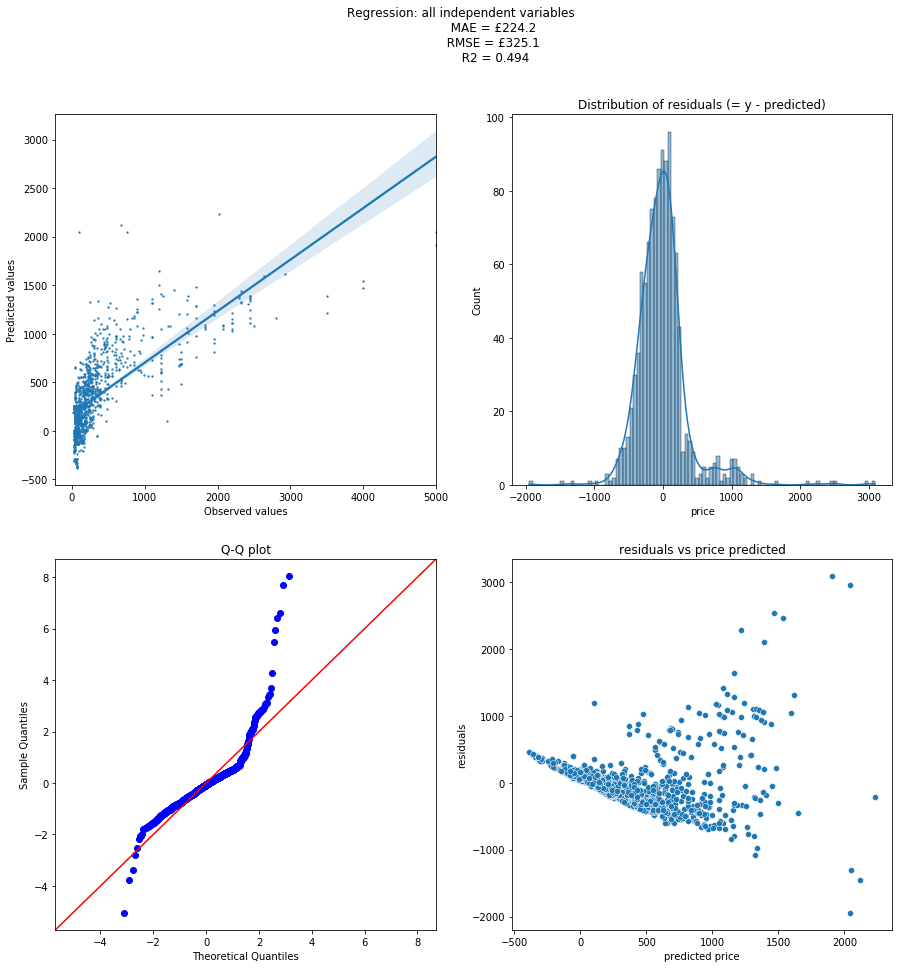

In [11]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

reg_plots(regressor(X, y, LinearRegression()), 'all independent variables', order=1)

## All variables and polynomials to degree = 2

intercept: 342.4
coefficients: {'x0': -18.64508616593927, 'x1': 63.398534289933785, 'x2': -120.60607836556912, 'x3': -405.6282621272222, 'x4': -103.85922719056842, 'x5': 266.7591273422435, 'x6': 120.27506226031409, 'x7': 53.38114621790561, 'x8': 74.93556900331873, 'x9': -261.5126691339757, 'x10': -118.48446765436097, 'x11': -617.5801675982963, 'x12': -14.265845317608067, 'x0^2': -0.37162601989300015, 'x0 x1': 5.451163436265361, 'x0 x2': 18.03477234814214, 'x0 x3': 39.899647592724264, 'x0 x4': 2.47006056049446, 'x0 x5': -18.705797666804468, 'x0 x6': -23.794606968298957, 'x0 x7': -19.437249570196236, 'x0 x8': 8.652598701815256, 'x0 x9': 18.26481032396987, 'x0 x10': 4.425614894050383, 'x0 x11': 340.5153348192128, 'x0 x12': 2.162971792821395, 'x1^2': 63.398534289834544, 'x1 x2': -6.707523425575346e-12, 'x1 x3': -1.0803358208022473e-11, 'x1 x4': -126.127848994171, 'x1 x5': 1.1155520951433573e-11, 'x1 x6': -1.5518253349000588e-11, 'x1 x7': -241.04100856065472, 'x1 x8': -5.684341886080801e-13

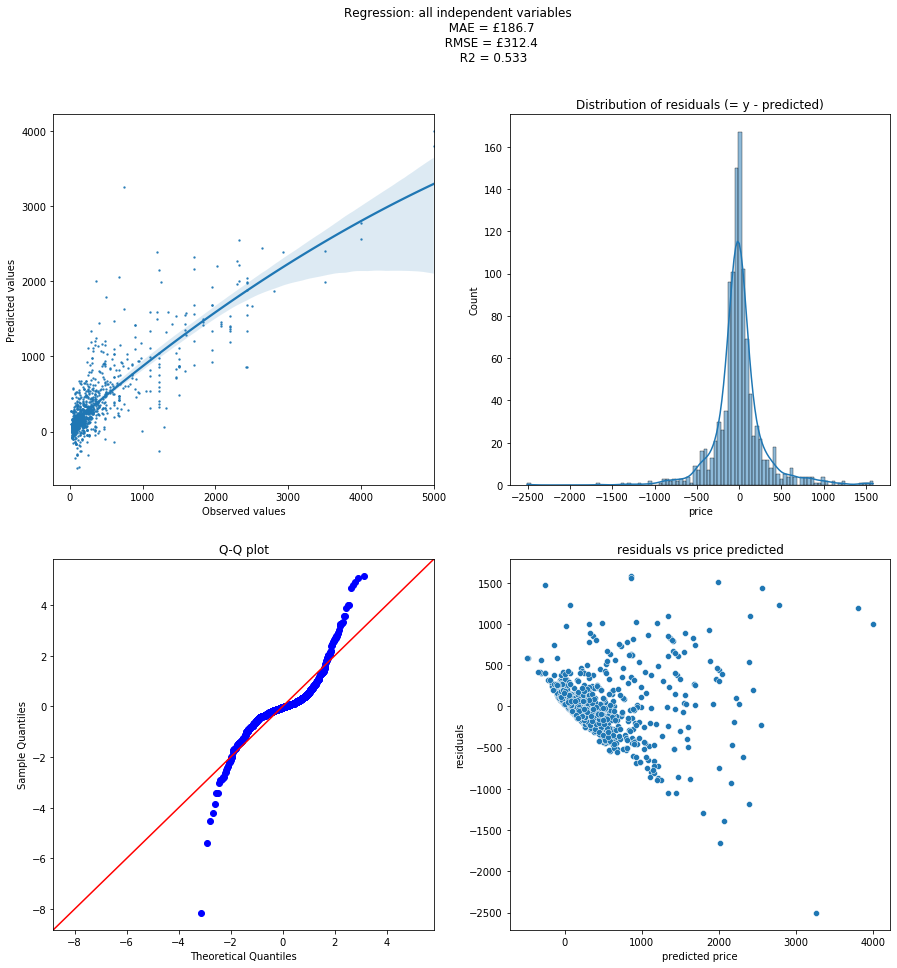

In [12]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']


# Define a PolynomialFeatures transformer with degree=2 and include_bias=False
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit transform the training data
X = poly.fit_transform(X)

X = pd.DataFrame(data=X, columns=poly.get_feature_names())

reg_plots(regressor(X, y, LinearRegression()), 'all independent variables',order=2)

## Log transformation regression (Simple)

In [23]:
def log_regressor(X, y, regression_class):
    
    y=np.log(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

    lin_reg = regression_class
    lin_reg.fit(X_train, y_train)
    
    
#     lin_reg = TransformedTargetRegressor(regressor=regression_class,
#                                         func=np.log,
#                                         inverse_func=np.exp)
    
#     lin_reg.fit(X_train, y_train)
    

#     print('intercept:', round(lin_reg.intercept_, 1))
#     print('coefficients:', dict(zip(X.columns, lin_reg.coef_)))

    preds_train = lin_reg.predict(X_train)
    preds_test = lin_reg.predict(X_test)
    preds_all = lin_reg.predict(X)
    residuals = y - preds_all
    
    return X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals

# calculate regression errors
def reg_errors(y_test, preds_test):
    
    mae = mean_absolute_error(y_test, preds_test)
    rmse = mean_squared_error(y_test, preds_test, squared=False)
    r2 = r2_score(y_test, preds_test)
    
    return mae, rmse, r2

#plot of regression and it's assumptions.
# func argument can be the regressor function, or any other function. log_regressor and lasso_regressor are others.
def log_reg_plots(func, string_description, order):
    
    X_train, X_test, y_train, y_test, preds_train, preds_test, preds_all, residuals = func

    mae, rmse, r2 = reg_errors(y_test, preds_test)
    
    fig, axes = plt.subplots(2,2,figsize=(15,15))

    fig.suptitle("Regression: {}\n \
                 MAE = £{} \n \
                 RMSE = £{} \n \
                 R2 = {}".format(string_description, round(mae, 1), round(rmse, 1), round(r2,3)))

    sns.regplot(x=y, y=preds_all, ax=axes[0,0], scatter_kws={'s': 2}, order=order)
    axes[0,0].set_xlabel("Observed values")
    axes[0,0].set_ylabel("Predicted values")
    axes[0,0].set_xlim([0, 3000])
    axes[0,0].set_ylim([0, 3000])

    
    sns.histplot(np.log(residuals), kde = True, bins = 100, ax=axes[0,1])
    axes[0,1].set_title("Distribution of log(residuals)")

    qqplot(np.log(residuals), line='45', fit=True, ax=axes[1,0])
    axes[1,0].set_title("Q-Q plot")

    sns.scatterplot(x=np.log(preds_all), y=np.log(residuals), ax=axes[1,1])
    axes[1,1].set_xlabel("predicted price")
    axes[1,1].set_ylabel("residuals")
    axes[1,1].set_title("residuals vs price predicted")

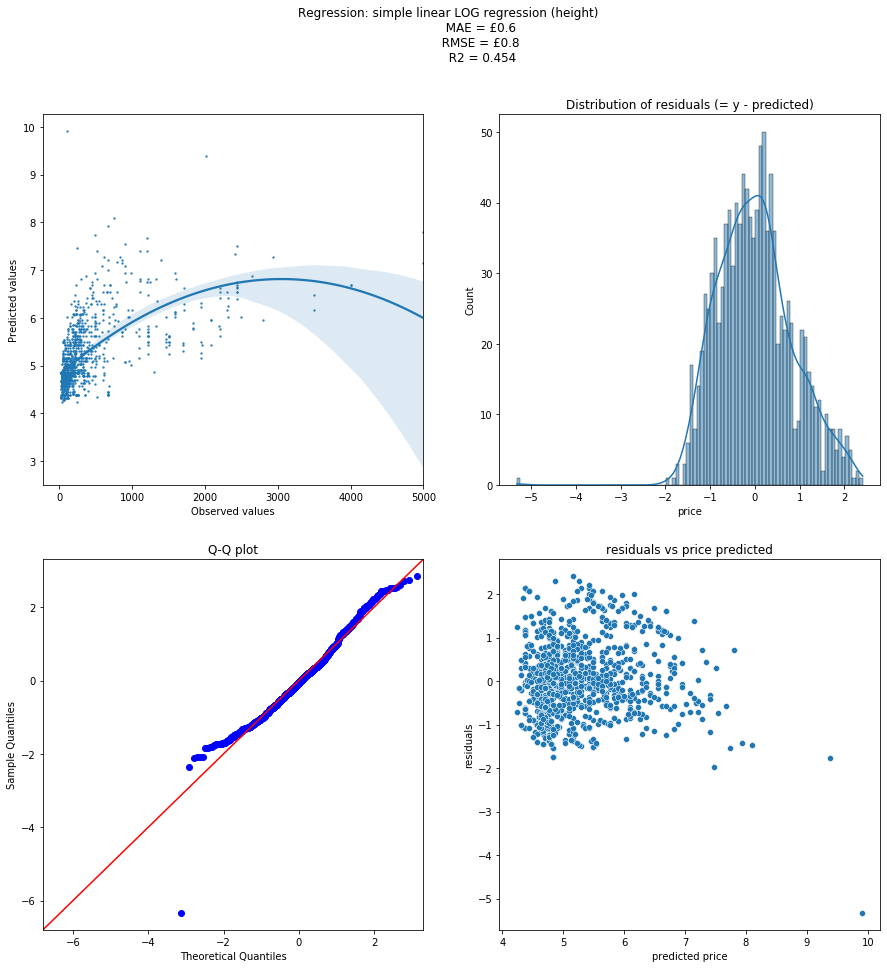

In [27]:
X = pots_reg[['height']]
y = pots_reg['price']

reg_plots(log_regressor(X, y, LinearRegression()), 'simple linear LOG regression (height)', order=2)

## Log transformation regression (multiple)

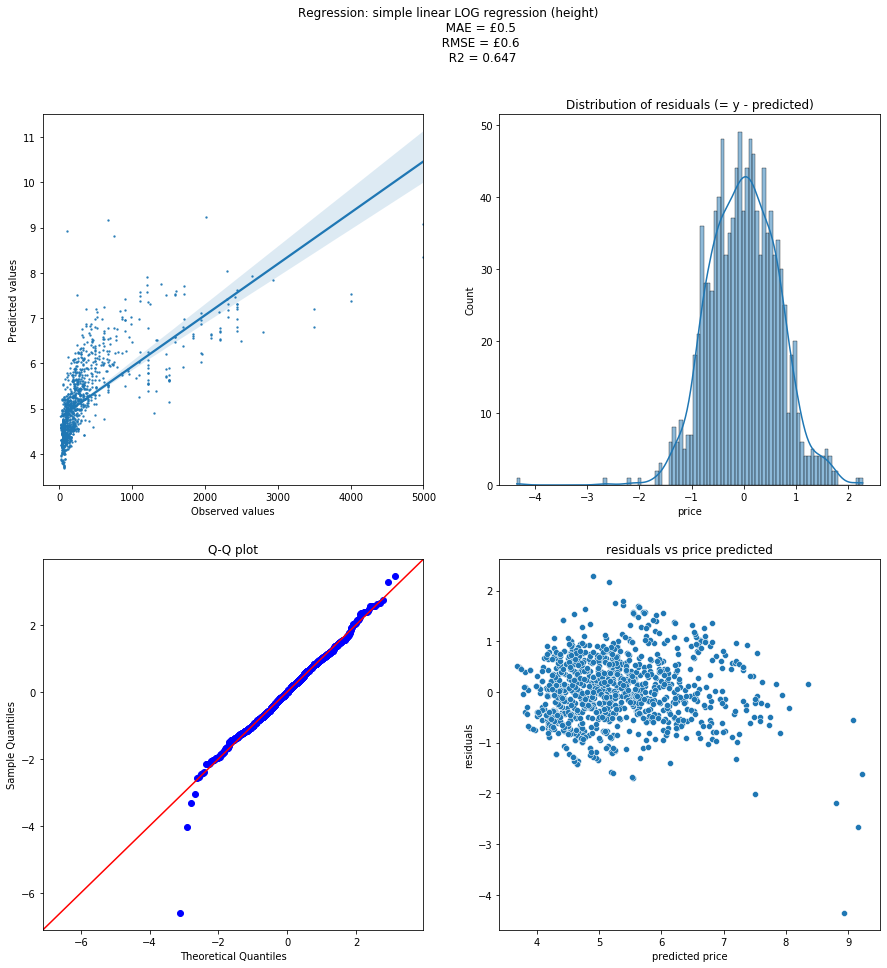

In [28]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

reg_plots(log_regressor(X, y, LinearRegression()), 'simple linear LOG regression (height)', order=1)

## Log transformation, multiple regression, polynomial order = 2

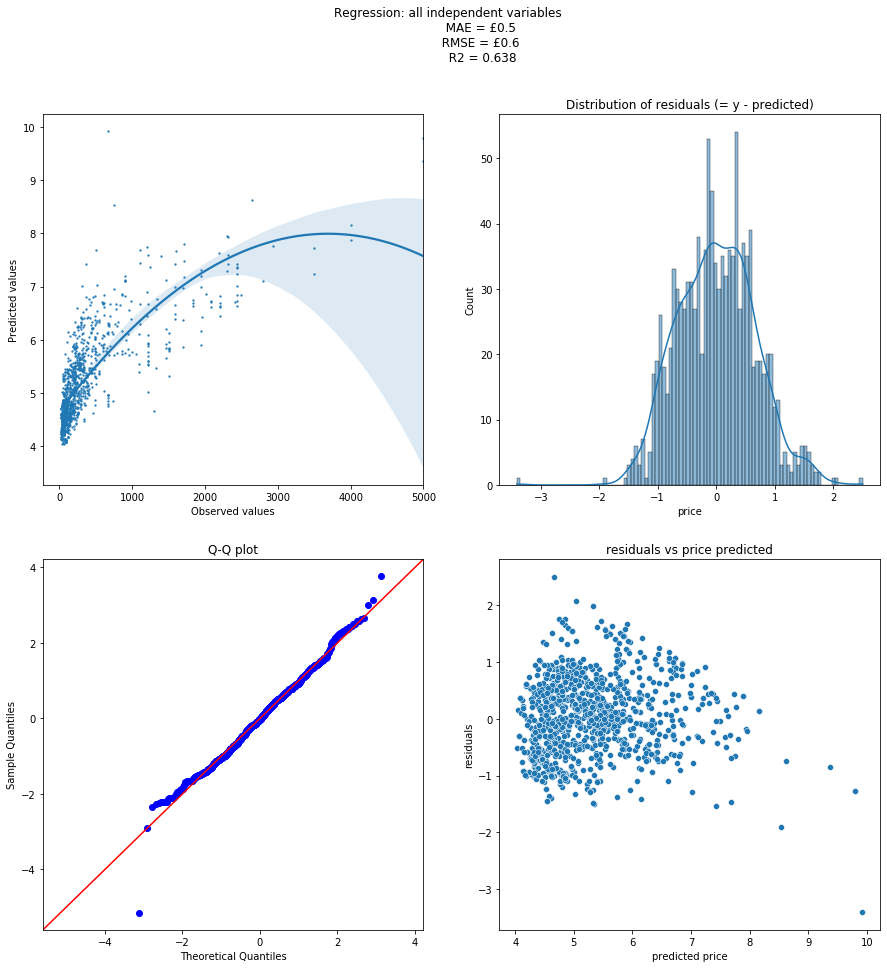

In [30]:
X = pots_reg[['height', 'materials_Earthenware', 'materials_Porcelain',
       'materials_Stoneware', 'technique_Thrown', 'firing_Gas', 'firing_Raku',
       'firing_Wood', 'decoration_Lustre', 'decoration_Sgraffito',
       'decoration_Slip decoration', 'decoration_Terra Sigillata', 'length']]
y = pots_reg['price']

# Define a PolynomialFeatures transformer with degree=2 and include_bias=False
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit transform the training data
X = poly.fit_transform(X)

X = pd.DataFrame(data=X, columns=poly.get_feature_names())

reg_plots(log_regressor(X, y, LassoCV()), 'all independent variables',order=2)